## Testing hypothesis 3
---

**_Hypothesis_**: Reviews with higher book rating have higher helpfulness ratings.

   - **Metric**: Correlation between book ratings and helpfulness ratings.

   - **Model**: Linear Regression

   - **Description**:

     - Use the book rating as the predictor variable and the helpfulness rating as the target variable.
     - Train a linear regression model to predict helpfulness ratings based on book ratings.

**Missing Values**:

  - `review/score`: remove the entire sample
  - `review/helpfulness`: remove the entire sample

**Data Transformation**:
  - `review/score`: groupBy book title and calculate the average score.
  - `review/helpfulness`: $helpfulness = \frac{x}{y} \sqrt(y)$

---

In [1]:
# Connect to MongoDB

import pymongo

client = pymongo.MongoClient('mongodb://localhost:27017/')
database = client['spark_db']
books = database['books_hypothesis_3']

The shape of the data is (141409, 3)


<AxesSubplot: title={'center': 'Average Helpfulness Rate for each Score'}, xlabel='review/score'>

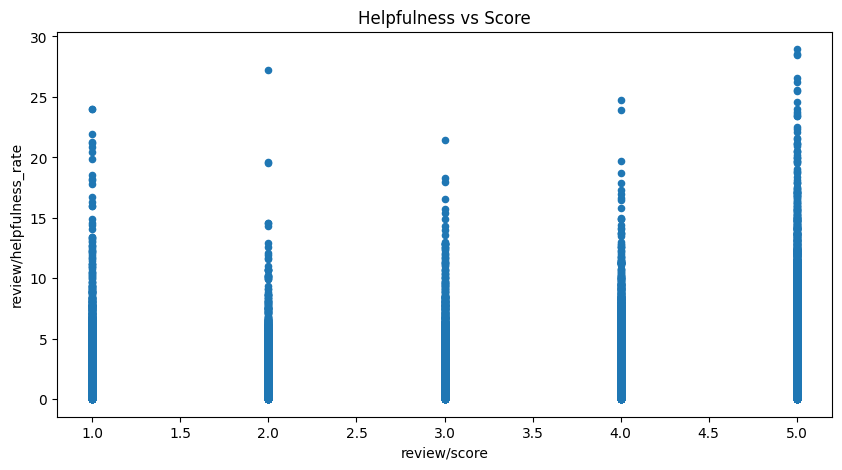

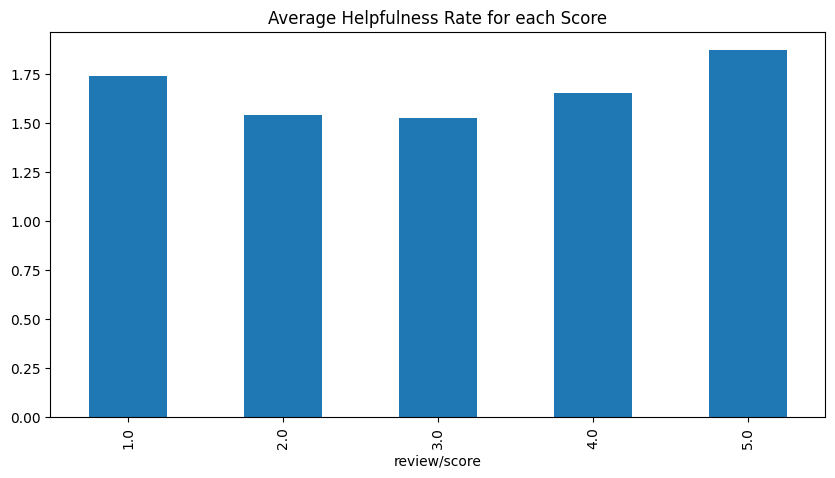

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Remove the samples which have no score or helpfulness data
pipeline_remove = {'$match':{
                        'review/score':{'$exists':True},
                        'review/helpfulness':{'$exists':True, '$ne':'0/0'} 
                        }
    
                }

# Retain only the required fields
pipeline_project = {'$project':{
                            'review/score':1,
                            'review/helpfulness':1,
                            '_id':0
                                }
                }   

books_data = books.aggregate([pipeline_remove,pipeline_project])

# Convert into Pandas DataFrame
df_data = pd.DataFrame(list(books_data))

# Convert the helpfulness column into a float
df_data['review/helpfulness_rate'] = df_data['review/helpfulness'].apply(lambda x: ((int(x[0:x.index('/')])/int(x[(x.index('/')+1):]))*np.sqrt(float(x[(x.index('/')+1):]))))

# Check the shape of the data
print(f"The shape of the data is {df_data.shape}")

# Plot the results
df_data.plot(kind='scatter', x='review/score', y='review/helpfulness_rate', title='Helpfulness vs Score', figsize=(10,5))

# Compute the average helpfulness rate for each score
plt.figure()
df_data.groupby('review/score')['review/helpfulness_rate'].mean().plot(kind='bar', title='Average Helpfulness Rate for each Score', figsize=(10,5))

### Compute statistics

---

The statistics are used to numerically asses the results of the hypothesis test.

In [47]:
import scipy.stats as stats

# Check if the data are normally distributed
score_ntest, p_value_score_ntest = stats.normaltest(df_data['review/score'])
help_ntest, p_value_help_ntest = stats.normaltest(df_data['review/helpfulness'])

# Print the conclusion
if p_value_score_ntest < 0.05:
    print(f"The p-value for normality test of review/score is {p_value_score_ntest}. The data is not normally distributed.")
else:
    print(f"The p-value for normality test of review/score is {p_value_score_ntest}. The data is normally distributed.")

if p_value_help_ntest < 0.05:
    print(f"The p-value for normality test of review/helpfulness is {p_value_help_ntest}. The data is not normally distributed.")
else:
    print(f"The p-value for normality test of review/helpfulness is {p_value_help_ntest}. The data is normally distributed.")
    
# Check the correlation between the two variables
person_coeff, p_value_corr = stats.spearmanr(df_data['review/score'], df_data['review/helpfulness'])

# Print the conclusion
if p_value_corr < 0.05:
    print(f"The p-value for correlation between review/score and review/helpfulness is {p_value_corr}. The correlation is not significant.")
else:
    print(f"The p-value for correlation between review/score and review/helpfulness is {p_value_corr}. The correlation is significant.")
    
# Check if the two variables follow same distribution
ks_stat, p_value_ks = stats.ks_2samp(df_data['review/score'], df_data['review/helpfulness'])

# Print the conclusion
if p_value_ks < 0.05:
    print(f"The p-value for Kolmogorov-Smirnov test between review/score and review/helpfulness is {p_value_ks}. The two variables do not follow the same distribution.")
else:
    print(f"The p-value for Kolmogorov-Smirnov test between review/score and review/helpfulness is {p_value_ks}. The two variables follow the same distribution.")
    
# Check if the two variables are independent
chi2_stat, p_value_chi2, dof, expected = stats.chi2_contingency(pd.crosstab(df_data['review/score'], df_data['review/helpfulness']))

# Print the conclusion
if p_value_chi2 < 0.05:
    print(f"The p-value for Chi-Square test between review/score and review/helpfulness is {p_value_chi2}. The two variables are not independent.")
else:
    print(f"The p-value for Chi-Square test between review/score and review/helpfulness is {p_value_chi2}. The two variables are independent.")

# Check if the mean of the two variables are equal using Wilcoxon
wilcoxon_stat, p_value_wilcoxon = stats.wilcoxon(df_data['review/score'], df_data['review/helpfulness'])

# Print the conclusion
if p_value_wilcoxon < 0.05:
    print(f"The p-value for Wilcoxon test between review/score and review/helpfulness is {p_value_wilcoxon}. The two variables do not have the same mean.")
else:
    print(f"The p-value for Wilcoxon test between review/score and review/helpfulness is {p_value_wilcoxon}. The two variables have the same mean.")


The p-value for normality test of review/score is 0.0. The data is not normally distributed.
The p-value for normality test of review/helpfulness is 0.0. The data is not normally distributed.
The p-value for correlation between review/score and review/helpfulness is 2.116689154375177e-152. The correlation is not significant.
The p-value for Kolmogorov-Smirnov test between review/score and review/helpfulness is 0.0. The two variables do not follow the same distribution.
The p-value for Chi-Square test between review/score and review/helpfulness is 0.0. The two variables are not independent.
The p-value for Wilcoxon test between review/score and review/helpfulness is 0.0. The two variables do not have the same mean.


## Further Analysis on a subset of the data

---

From the previous analysis the following emerged:
- A sort of correlation exists between the helpfulness and the book rating when this latter is at the extremes of the scale.
- The helpfulness score should not be considered when the number of votes is low
    - PROBLEM: removing the low number of votes will result in a very small dataset

The shape of the data is (1069, 3)


<AxesSubplot: title={'center': 'Average Helpfulness Rate for each Score'}, xlabel='review/score'>

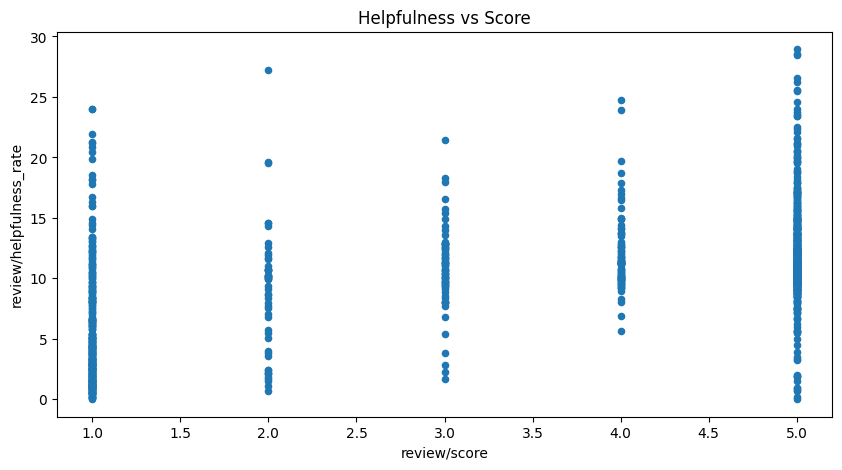

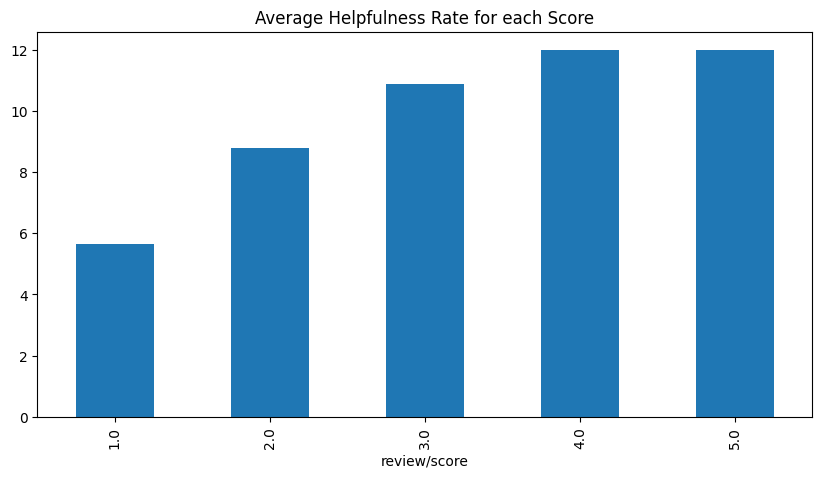

In [61]:
# Remove sample below 100 helpfulness votes
min_votes = 100
filter = df_data['review/helpfulness'].apply(lambda x: int(x[(x.index('/')+1):])) > min_votes
df_data_filtered = df_data[filter]

# Check the shape of the data
print(f"The shape of the data is {df_data_filtered.shape}")

# Plot the results
df_data_filtered.plot(kind='scatter', x='review/score', y='review/helpfulness_rate', title='Helpfulness vs Score', figsize=(10,5))

# Compute the average helpfulness rate for each score
plt.figure()
df_data_filtered.groupby('review/score')['review/helpfulness_rate'].mean().plot(kind='bar', title='Average Helpfulness Rate for each Score', figsize=(10,5))

The shape of the data is (1069, 4)


/tmp/ipykernel_996/503548111.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_filtered['review/score_grouped'] = df_data_filtered['review/score'].apply(lambda x: 1 if x==1 or x==5 else 0)


<AxesSubplot: title={'center': 'Helpfulness vs Score'}, xlabel='review/score_grouped', ylabel='review/helpfulness_rate'>

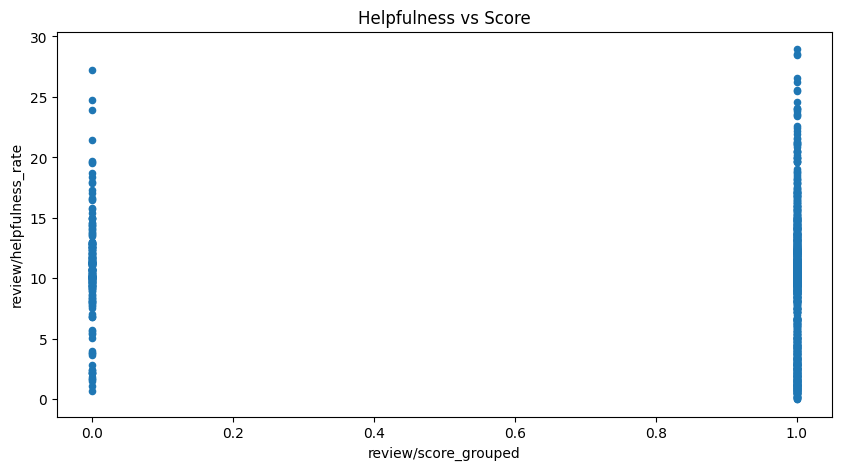

In [57]:
# Group the data having score 1,5 together and 2,3,4 together
df_data_filtered['review/score_grouped'] = df_data_filtered['review/score'].apply(lambda x: 1 if x==1 or x==5 else 0)

# Check the shape of the data
print(f"The shape of the data is {df_data_filtered.shape}")

# Plot the results
df_data_filtered.plot(kind='scatter', x='review/score_grouped', y='review/helpfulness_rate', title='Helpfulness vs Score', figsize=(10,5))